# Performance Counters

Fiddle provide easy access to hardware performance counters to count things like cache misses and branch mispredictions.

<div class="alert alert-block alert-warning">

In order for performance counters to work, you need access to your hardware's performance counters.   You can check the [perf_event_open man page](https://man7.org/linux/man-pages/man2/perf_event_open.2.html) for details about how to enable the `perf_events` interface on your system (It's usually turned on by default).

If you're in docker, you'll also need to start the container with `--privileged`.
    
</div>

Let's use to investigate the performance difference between `std::ordered_set` and `std::set` in the C++ STL.

## The Code

The code provides two functions that each fill a set with random integers.  We'll compile it with full optimizations.

In [1]:
from fiddle import *
from fiddle.perfcount import *
configure_for_jupyter()

In [2]:
exe = build(code(r"""
#include<set>
#include<unordered_set>
#include"fiddle.hpp"

extern "C"
int build_set(int count) {
    std::set<uint64_t> s;
    uint64_t seed = 0xDEADBEEF;
    start_measurement();
    for(int i= 0; i < count; i++) {
        s.insert(fast_rand(&seed));
    }
    end_measurement();
    return s.size();
}

extern "C"
int build_unordered_set(int count) {
    std::unordered_set<uint64_t> s;
    uint64_t seed = 0xDEADBEEF;
    start_measurement();
    for(int i= 0; i < count; i++) {
        s.insert(fast_rand(&seed));
    }
    end_measurement();
    return s.size();
}

"""), arg_map(OPTIMIZE="-O3"))

  0%|          | 0/1 [00:00<?, ?it/s]

## Measuring Cache Misses and Instructions Executed

Here's the command to run the program and measure performance counters:

In [3]:
def exp_range(base, low, high):
    return [2**i for i in range(low,high)]

results = run(exe, 
              ["build_set", "build_unordered_set"], 
              arg_map(count=exp_range(2,8,24)), 
              perf_counters=[CacheCounter(L1D, READ, MISS),
                             INSTRUCTIONS])

  0%|          | 0/32 [00:00<?, ?it/s]

The key is the `perf_counters` parameter which takes a list of performance counters to measure.  Fiddle supports all the hardware, software, and cache counters described in the [perf_event_open() man page](https://man7.org/linux/man-pages/man2/perf_event_open.2.html).  In this case, we'll count the number of level-1 data cach (`L1D`), read misses and the total number instructions executed.

We use Pandas data from opererations to compute some dervived metrics:

In [4]:
r = results.as_df()
r['L1_MissPerInsert'] = r["L1D_READ_MISS"]/r["count"]
r['InstPerInsert'] = r["INSTRUCTIONS"]/r["count"]
r['L1_MPI'] = r["L1D_READ_MISS"]/r["INSTRUCTIONS"]
display(r)

,OPTIMIZE,function,count,ET,L1D_READ_MISS,INSTRUCTIONS,L1_MissPerInsert,InstPerInsert,L1_MPI
0,-O3,build_set,256,0.000164,615,107446,2.402344,419.710938,0.005724
1,-O3,build_set,512,0.000156,1353,224585,2.642578,438.642578,0.006024
2,-O3,build_set,1024,0.000278,3761,461362,3.672852,450.548828,0.008152
3,-O3,build_set,2048,0.000501,10080,931511,4.921875,454.839355,0.010821
4,-O3,build_set,4096,0.001112,27132,1884860,6.624023,460.170898,0.014395
5,-O3,build_set,8192,0.001683,67695,3736751,8.263550,456.146362,0.018116
6,-O3,build_set,16384,0.003467,162920,7361337,9.943848,449.300354,0.022132
7,-O3,build_set,32768,0.007358,372114,14837922,11.356018,452.817444,0.025079
8,-O3,build_set,65536,0.016369,866694,30040458,13.224701,458.381012,0.028851
9,-O3,build_set,131072,0.037212,2062988,61027419,15.739349,465.602257,0.033804


And then we can reshuffle that data to make comparisons and plotting easier:

In [5]:
import pandas as pd
pt = pd.pivot_table(r, index="count", values=["InstPerInsert", "L1_MissPerInsert", "ET"], columns="function")
display(pt)

ET                     InstPerInsert                      \
function build_set build_unordered_set     build_set build_unordered_set   
count                                                                      
256       0.000164            0.000034    419.710938          356.605469   
512       0.000156            0.000062    438.642578          364.082031   
1024      0.000278            0.000121    450.548828          365.478516   
2048      0.000501            0.000239    454.839355          365.473145   
4096      0.001112            0.000447    460.170898          362.347656   
8192      0.001683            0.000901    456.146362          359.681396   
16384     0.003467            0.001805    449.300354          352.228149   
32768     0.007358            0.003678    452.817444          347.303284   
65536     0.016369            0.006987    458.381012          344.994095   
131072    0.037212            0.013521    465.602257          343.909813   
262144    0.084033            0.035075    473.181736          343.574497   
524288    0.203288            0.090677    481.172791          343.570755   
1048576   0.504145            0.241216    489.353728          343.732786   
2097152   1.233180            0.586494    497.500620          344.008288   
4194304   3.113400            1.445980    505.465115          344.334201   
8388608   7.865600            3.412970    513.539684          344.695965   

         L1_MissPerInsert                      
function        build_set build_unordered_set  
count                                          
256              2.402344            1.609375  
512              2.642578            1.615234  
1024             3.672852            2.005859  
2048             4.921875            2.969727  
4096             6.624023            3.903809  
8192             8.263550            4.801514  
16384            9.943848            5.367920  
32768           11.356018            5.704590  
65536           13.224701            5.959473  
131072          15.739349            6.156654  
262144          17.796463            6.630096  
524288          20.581100            7.445488  
1048576         23.502500            8.418393  
2097152         27.622739            9.342690  
4194304         30.616819           10.077693  
8388608         32.809326           10.619132

## The Results

The results provide some insight into why `std::ordered_set` is roughly twice as fast at as `std::set` for inserts: While the number of instructions per access grows pretty slowly, the number _cache misses_ per accesses grows much faster for `std::set`  than `std::ordered_set`.

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kb9o7jan because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<AxesSubplot:xlabel='count', ylabel='ET'>

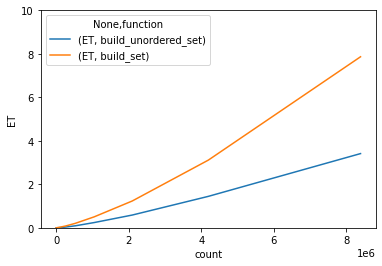

In [6]:
pt.plot.line(y=[("ET", "build_unordered_set"), ("ET", "build_set")], ylim=(0,10), ylabel="ET")

<AxesSubplot:xlabel='count', ylabel='Instruction Per Insert'>

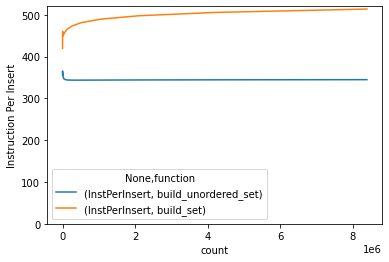

In [7]:
pt.plot.line(y=[("InstPerInsert", "build_unordered_set"), ("InstPerInsert", "build_set")], ylim=(0,520), ylabel="Instruction Per Insert")

<AxesSubplot:xlabel='count', ylabel='Misses per Insert'>

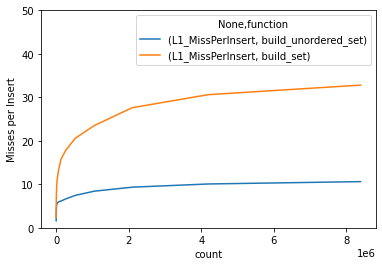

In [8]:
pt.plot.line(y=[("L1_MissPerInsert", "build_unordered_set"), ("L1_MissPerInsert", "build_set")], ylim=(0,50), ylabel="Misses per Insert")